Dataset downloaded successfully! an outdated `kagglehub` version (installed: 0.3.7), please consider upgrading to the latest version (0.3.11).

shape after dropping NAs: (170653, 19)kagglehub` version (installed: 0.3.7), please consider upgrading to the latest version (0.3.11).


Regression Results (on Test Set):, 19)kagglehub` version (installed: 0.3.7), please consider upgrading to the latest version (0.3.11).





,Model,Alpha,MSE,R2
0,Linear,0.01,265.901343,0.444322
1,Ridge,0.01,265.901343,0.444322
2,Lasso,0.01,265.908633,0.444307
3,Linear,0.10,265.901343,0.444322
4,Ridge,0.10,265.901344,0.444322
5,Lasso,0.10,266.078091,0.443953
6,Linear,1.00,265.901343,0.444322
7,Ridge,1.00,265.901351,0.444322
8,Lasso,1.00,276.553382,0.422062
9,Linear,10.00,265.901343,0.444322


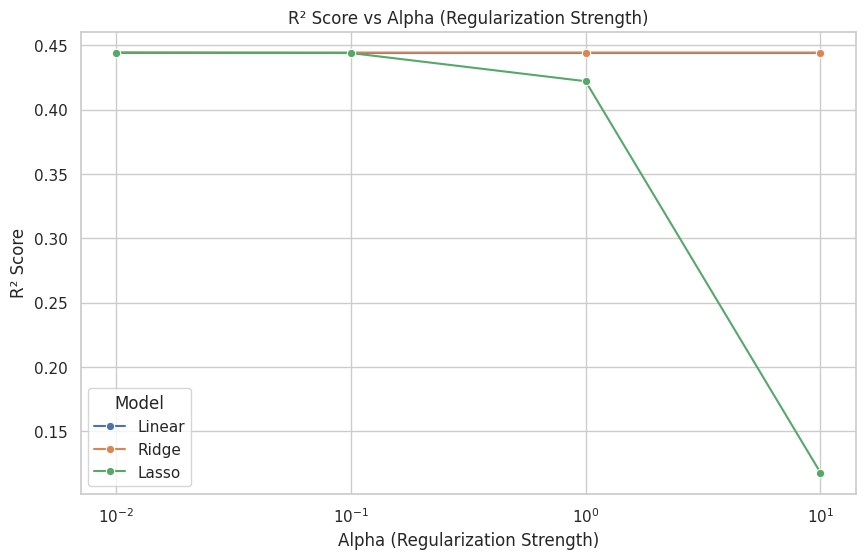


Logistic Regression Accuracy: 0.8982

Classification Report:
              precision    recall  f1-score   support

 Not Popular       0.90      1.00      0.95     30588
     Popular       0.59      0.06      0.11      3543

    accuracy                           0.90     34131
   macro avg       0.75      0.53      0.53     34131
weighted avg       0.87      0.90      0.86     34131



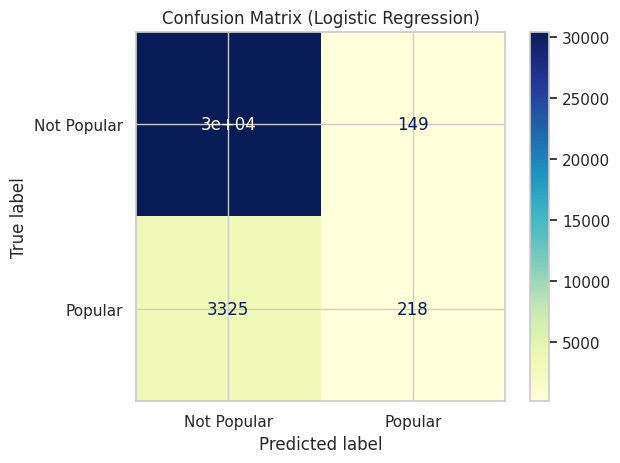

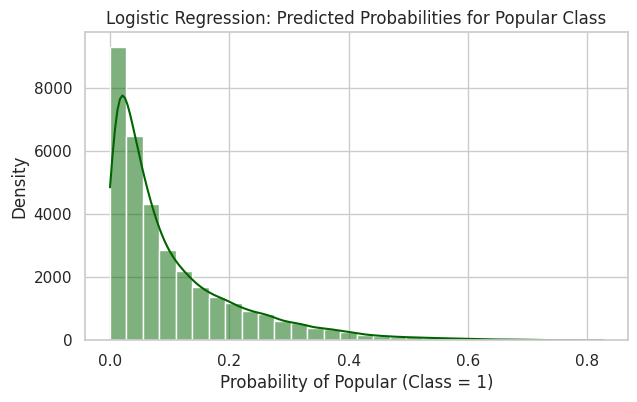

Concluding Remarks:
- Linear regression gives a baseline for modeling track popularity.
- Ridge and Lasso regularization help control overfitting by penalizing model complexity.
- Logistic regression was effective in classifying songs into Popular/Not Popular with reasonable accuracy.
- Regularization parameter (alpha) critically affects performance—must be tuned carefully.
- Future work may involve cross-validation, polynomial regression, or feature engineering.


In [1]:
# =============================================================================
# Lab 7: Regression Models – Linear, Ridge, Lasso, Logistic Regression
# =============================================================================

# Aim:
# To implement various regression models (Linear, Ridge, Lasso)
# and Logistic Regression for binary classification tasks on the Spotify dataset.

# Objective:
# 1. Compare Linear, Ridge, and Lasso Regression models under different α values.
# 2. Evaluate model performance on regression metrics (MSE, R²).
# 3. Implement Logistic Regression for classifying popular tracks.
# 4. Compare logistic classification metrics and visualize predictions.

# =============================================================================
# Libraries
# =============================================================================

import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error, r2_score,
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
)

import kagglehub
import warnings
warnings.filterwarnings("ignore")
sns.set(style='whitegrid')
%matplotlib inline

# =============================================================================
# Data Description & Loading
# =============================================================================

def download_data():
    print("Downloading dataset...")
    path = kagglehub.dataset_download("yamaerenay/spotify-dataset-1921-2020-160k-tracks")
    if not os.path.exists('data.csv'):
        for root, dirs, files in os.walk(path):
            if 'data.csv' in files:
                shutil.copy2(os.path.join(root, 'data.csv'), 'data.csv')
                break
    if os.path.exists('data.csv'):
        print("Dataset downloaded successfully!")
        return pd.read_csv('data.csv')
    else:
        raise FileNotFoundError("data.csv not found after download.")

df = download_data()

features = [
    'acousticness', 'danceability', 'duration_ms', 'energy',
    'instrumentalness', 'liveness', 'loudness', 'mode',
    'speechiness', 'tempo', 'valence'
]
target = 'popularity'

df = df.dropna(subset=features + [target])
print(f"Dataset shape after dropping NAs: {df.shape}")

# Split into features/target for regression
X = df[features].values
y = df[target].values

# Binary target for logistic regression
df['popularity_binary'] = (df[target] >= 60).astype(int)
y_binary = df['popularity_binary'].values

# =============================================================================
# Train-Test Split & Scaling
# =============================================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
_, _, y_binary_train, y_binary_test = train_test_split(
    X, y_binary, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =============================================================================
# Linear, Ridge, and Lasso Regression
# =============================================================================

alphas = [0.01, 0.1, 1.0, 10.0]

results = []

for alpha in alphas:
    models = {
        'Linear': LinearRegression(),
        'Ridge': Ridge(alpha=alpha),
        'Lasso': Lasso(alpha=alpha)
    }
    
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results.append((name, alpha, mse, r2))

# Results DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'Alpha', 'MSE', 'R2'])
print("Regression Results (on Test Set):")
display(results_df)

# Plot R² scores vs alpha
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='Alpha', y='R2', hue='Model', marker='o')
plt.title("R² Score vs Alpha (Regularization Strength)")
plt.xscale('log')
plt.ylabel("R² Score")
plt.xlabel("Alpha (Regularization Strength)")
plt.grid(True)
plt.show()

# =============================================================================
# Logistic Regression for Classification
# =============================================================================

logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_binary_train)

y_pred_class = logreg.predict(X_test_scaled)
y_prob = logreg.predict_proba(X_test_scaled)[:, 1]

acc = accuracy_score(y_binary_test, y_pred_class)
cm = confusion_matrix(y_binary_test, y_pred_class)

print(f"\nLogistic Regression Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_binary_test, y_pred_class, target_names=["Not Popular", "Popular"]))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Popular", "Popular"])
disp.plot(cmap='YlGnBu')
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()

# Probability histogram
plt.figure(figsize=(7, 4))
sns.histplot(y_prob, bins=30, kde=True, color='darkgreen')
plt.title("Logistic Regression: Predicted Probabilities for Popular Class")
plt.xlabel("Probability of Popular (Class = 1)")
plt.ylabel("Density")
plt.show()

# =============================================================================
# Concluding Remarks
# =============================================================================

print("Concluding Remarks:")
print("- Linear regression gives a baseline for modeling track popularity.")
print("- Ridge and Lasso regularization help control overfitting by penalizing model complexity.")
print("- Logistic regression was effective in classifying songs into Popular/Not Popular with reasonable accuracy.")
print("- Regularization parameter (alpha) critically affects performance—must be tuned carefully.")
print("- Future work may involve cross-validation, polynomial regression, or feature engineering.")
